# 1.  Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile, chi2
from sklearn.metrics import recall_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

# 2. Defaults

In [2]:
seed = 12 # 12 ears
y = 'OverallPoF' # target
dataset_dir = '00 - Dataset/03 - Sampling Splits/'

# feature selection threshold
l1_threshold = None
l2_threshold = '2.0 * mean'

# library options
plt.rcParams[ 'figure.figsize' ] = (16, 9) # larger plots
plt.rcParams[ 'font.size' ] = '16' # larger fonts
pd.set_option('display.max_colwidth', None) # print evth in pd df

params = { }

# sfm parameters
params[ 'sfm' ] = {
    'f_selector__threshold': [ 
        '1.00 * mean', '1.25 * mean', '1.50 * mean', '1.75 * mean', 
        '2.00 * mean', '2.25 * mean', '2.50 * mean', '2.75 * mean', 
        '3.00 * mean', '3.25 * mean', '3.50 * mean', '3.75 * mean',
        '4.00 * mean', '4.25 * mean', '4.50 * mean', '4.75 * mean', 
    ],
    'f_selector__max_features': [
        5, 6, 7
    ]
}

# cv parameters
params[ 'cv' ] = {
    'cv': 10, # k-fold
    'n_jobs': -1, # use all cpu cores
    'scoring': 'recall_macro',
    'return_train_score': True
}

# classifier parameters
params[ 'base' ] = {
    'dual': False,
    'random_state': seed,
    'max_iter': 23220451 * 12,
    'class_weight': 'balanced'
}
params[ 'hyper' ] = {
    'penalty': [ 'l1', 'l2' ],
    'C': [ 0.01, 0.1, 1, 10, 100 ]
}

# 3. Datasets

In [3]:
datasets = { }
for sample in next(os.walk(dataset_dir))[ 1 ]:
    sample_name = sample.split(' - ')[ 1 ]
    sample_dir = dataset_dir + sample + '/'
    
    # X
    X_train = pd.read_csv(sample_dir + 'X_train.csv')
    X_val = pd.read_csv(sample_dir + 'X_val.csv')
    X_test = pd.read_csv(sample_dir + 'X_test.csv')
    
    # y
    y_train = pd.read_csv(sample_dir + 'y_train.csv')[ y ]
    y_val = pd.read_csv(sample_dir + 'y_val.csv')[ y ]
    y_test = pd.read_csv(sample_dir + 'y_test.csv')[ y ]
    
    # absorbance only
    X_train = X_train.filter(regex = r'fa[0-9]*')
    X_val = X_val.filter(regex = r'fa[0-9]*')
    X_test = X_test.filter(regex = r'fa[0-9]*')
    
    datasets[ sample_name ] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
    }

# 4. Functions

In [4]:
def ttest_refit(cv_results):
    splits = set([ 
        k.split('_')[ 0 ] for k in cv_results.keys() if k.startswith('split') 
    ])
    n_folds = len(cv_results[ 'params' ])
    
    # ttest significance whether train/test means differ
    significance = [ ]
    for i in range(n_folds):
        train_scores = [ ]
        test_scores = [ ]
        
        for split in splits:
            train_score = cv_results[ split + '_train_score' ][ i ]
            test_score = cv_results[ split + '_test_score' ][ i ]
            
            train_scores.append(train_score)
            test_scores.append(test_score)
        
        _, pvalue = stats.ttest_ind(
            train_scores, 
            test_scores,
            equal_var = False
        )
        
        if (pvalue > 0.05):
            significance.append(False)
        else:
            significance.append(True)
    
    # use cv's #1 rank as default index
    ranking = list(cv_results[ 'rank_test_score' ])
    chosen_idx = ranking.index(1)
    
    # loop through ranking to get non overfit best score
    for rank in sorted(ranking):
        idx = ranking.index(rank)
        if (significance[ idx ]):
            continue
        chosen_idx = idx
        break
        
    return chosen_idx

def sd_refit(cv_results):
    train_scores = list(cv_results[ 'mean_train_score' ])
    train_sd = list(cv_results[ 'std_train_score' ])
    test_scores = list(cv_results[ 'mean_test_score' ])
    test_sd = list(cv_results[ 'std_test_score' ])
    ranking = list(cv_results[ 'rank_test_score' ])
    
    significance = [ ]
    for i in range(len(train_sd)):
        train_bound = train_scores[ i ] - 2 * train_sd[ i ]
        test_bound = test_scores[ i ] + 2 * test_sd[ i ]
        sig = True
        if (test_bound >= train_bound):
            sig = False
        significance.append(sig)
        
    # use cv's #1 rank as default index
    chosen_idx = ranking.index(1)
    
    # loop through ranking to get non overfit best score
    for rank in sorted(ranking):
        idx = ranking.index(rank)
        if (significance[ idx ]):
            continue
        chosen_idx = idx
        break
    
    return chosen_idx

def diff_refit(cv_results):
    alpha = 0.05 # 5%
    train_scores = list(cv_results[ 'mean_train_score' ])
    test_scores = list(cv_results[ 'mean_test_score' ])
    ranking = list(cv_results[ 'rank_test_score' ])
    
    # use cv's #1 rank as default index
    chosen_idx = ranking.index(1)
    
    # loop through ranking to get non overfit best score
    for rank in sorted(ranking):
        idx = ranking.index(rank)
        diff = abs(train_scores[ idx ] - test_scores[ idx ])
        if (diff < 0.05):
            chosen_idx = idx
            break
            
    return chosen_idx

def extract_frequencies(columns):
    return ', '.join([ c[ 2 :  ] for c in columns ])

def conf_plot(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true = y_true, y_pred = y_pred)
    cf_flatten = cf_matrix.flatten()
    labels = [ 'TN','FP','FN','TP' ]
    counts = [ 
        '{0:0.0f}'.format(value) for value in cf_flatten
    ]
    percents = [ 
        '{0:.2%}'.format(value/ np.sum(cf_matrix)) for value in cf_flatten
    ]
    annots = [
        f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(labels, counts, percents)
    ]
    
    ax = sns.heatmap(
        fmt = '', 
        cbar = False,
        cmap = 'Blues',
        data = cf_matrix, 
        annot = np.asarray(annots).reshape(2, 2)
    )
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels([ 'negative', 'positive' ])
    ax.yaxis.set_ticklabels([ 'negative', 'positive' ])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
def roc_all_split(clf, sample):
    plt.figure()
    dataset = datasets[ sample ]
    splits = {
        'train': (dataset[ 'X_train' ], dataset[ 'y_train' ]),
        'val': (dataset[ 'X_val' ], dataset[ 'y_val' ]),
        'test': (dataset[ 'X_test' ], dataset[ 'y_test' ]),
    }

    for s in splits:
        X, y_true = splits[ s ]
        y_score = clf.decision_function(X)
        
        auc = roc_auc_score(y_true = y_true, y_score = y_score)
        fpr, tpr, _ = roc_curve(y_true = y_true, y_score = y_score)
        plt.plot(fpr, tpr, label = '%s (area = %0.2f)' % (s, auc))
    
    plt.plot([ 0, 1 ], [ 0, 1 ],'r--')
    plt.xlim([ 0.0, 1.0 ])
    plt.ylim([ 0.0, 1.01 ])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc = 'lower right')
    plt.show()
    
def plot_contributions(pipe, frequencies):
    clf = pipe[ 'classifier' ]
    print(clf.coef_)
    coef_plot = pd.Series(
        data = abs(clf.coef_[ 0 ]), 
        index = [ f for f in frequencies.split(', ') ]
    ).sort_values().plot(kind = 'barh')
    coef_plot.set_title('Frequencies\' Contribution')
    
def plot_correlation(columns, annot = True):
    corr = round(abs(X_train[ columns ].corr(method = 'pearson')), 2)
    
    mask = np.zeros_like(corr)
    mask[ np.triu_indices_from(mask) ] = True
    
    sns.heatmap(
        corr,
        cbar = False,
        mask = mask, 
        linewidths = .5, 
        annot_kws = { 'fontsize': 'small' },
        center = 0, 
        annot = True, 
        cmap = 'flare'
    )

def plot_absorbance(frequencies):
    full_data = pd.read_csv('00 - Dataset/02 - Cleaning Results/a_data.csv')
    full_data = full_data[ list(full_data.filter(regex = r'f[0-9]+').columns) + [ y ] ]

    full_data[ 'id' ] = full_data.index
    long_data = pd.wide_to_long(
        df = full_data,
        stubnames = [ 'f' ],
        i = 'id',
        j = 'frequencies'
    ).rename(columns = { 'f': 'absorbance' }).reset_index().iloc[  : , 1 :  ]

    plt.figure()
    chart = sns.lineplot(data = long_data, x = 'frequencies', y = 'absorbance', hue = 'OverallPoF')
    ymin, ymax = chart.get_ylim()

    # vertical lines
    chart.vlines(
        x = [ int(f) for f in frequencies.split(', ') ], 
        ymin = ymin, 
        ymax = ymax, 
        ls = '--', 
        lw = 1,
        colors = 'red'
    )
    plt.xlim([ 0.0, 9000 ])
    plt.ylim([ 0.0, ymax ])
    plt.show()

# 5. Pipelines

In [5]:
pipelines = { }

## 5.1. L1

In [6]:
pipelines[ 'l1_pipe' ] = Pipeline([
    (
        'f_scaler', 
        StandardScaler()
    ),
    (
        'f_selector', 
        SelectFromModel(
            estimator = LinearSVC(**params[ 'base' ], penalty = 'l1'),
            # max_features = 9,
            # threshold = l1_threshold,
        )
    ),
    (
        'classifier', 
        LinearSVC(**params[ 'base' ])
    )
])

In [7]:
# pipelines[ 'l1_pipe' ].get_params()

In [8]:
params[ 'l1_pipe' ] = {
    'classifier__C': params[ 'hyper' ][ 'C' ],
    'classifier__penalty': params[ 'hyper' ][ 'penalty' ],
    'f_selector__max_features': params[ 'sfm' ][ 'f_selector__max_features' ]
    # 'f_selector__threshold': params[ 'sfm' ][ 'f_selector__threshold' ],
}

## 5.2. L2

In [9]:
pipelines[ 'l2_pipe' ] = Pipeline([
    (
        'f_scaler', 
        StandardScaler()
    ),
    (
        'f_selector', 
        SelectFromModel(
            estimator = LinearSVC(**params[ 'base' ]),
            # max_features = 9,
            # threshold = l2_threshold,
        )
    ),
    (
        'classifier', 
        LinearSVC(**params[ 'base' ])
    )
])

In [10]:
# pipelines[ 'l2_pipe' ].get_params()

In [11]:
params[ 'l2_pipe' ] = {
    'classifier__C': params[ 'hyper' ][ 'C' ],
    'classifier__penalty': params[ 'hyper' ][ 'penalty' ],
    'f_selector__max_features': params[ 'sfm' ][ 'f_selector__max_features' ]
    # 'f_selector__threshold': params[ 'sfm' ][ 'f_selector__threshold' ],
}

# 6. Modelling

In [12]:
results = [ ] # container

In [13]:
for sample in datasets:
    X_train = datasets[ sample ][ 'X_train' ]
    y_train = datasets[ sample ][ 'y_train' ]
    X_val = datasets[ sample ][ 'X_val' ]
    y_val = datasets[ sample ][ 'y_val' ]
    
    for pipe in pipelines:
        grid = GridSearchCV(
            **params[ 'cv' ],
            refit = ttest_refit,
            param_grid = params[ pipe ],
            estimator = pipelines[ pipe ],
        )
        grid.fit(X_train, y_train)
        
        f_selector = grid.best_estimator_[ 'f_selector' ]
        classifier = grid.best_estimator_[ 'classifier' ]
        
        columns = X_train.columns[ f_selector.get_support() ]
        
        train_auc = roc_auc_score(
            y_true = y_train, 
            y_score = grid.decision_function(X_train)
        )
        val_auc = roc_auc_score(
            y_true = y_val, 
            y_score = grid.decision_function(X_val)
        )
        
        og_train_recall = recall_score(
            average = 'macro',
            y_true = datasets[ 'Original' ][ 'y_train' ],
            y_pred = grid.best_estimator_.predict(datasets[ 'Original' ][ 'X_train' ])
        )
        train_recall = recall_score(
            average = 'macro',
            y_true = y_train,
            y_pred = grid.best_estimator_.predict(X_train)
        )
        val_recall = recall_score(
            average = 'macro',
            y_true = y_val,
            y_pred = grid.best_estimator_.predict(X_val)
        )
        
        results.append({
            'pipe': grid.best_estimator_,
            'columns': columns,
            'parameters': classifier.get_params(),
            'sample': sample,
            'selection_method': 'embedded ' + pipe.split('_')[ 0 ],
            'threshold': f_selector.get_params()[ 'threshold' ],
            'n_features': len(columns),
            'frequencies': extract_frequencies(columns),
            # 'training_auc': round(train_auc * 100, 2),
            # 'validation_auc': round(val_auc * 100, 2),
            'training_recall': round(train_recall * 100, 2),
            'og_training_recall': round(og_train_recall * 100, 2),
            'validation_recall': round(val_recall * 100, 2)
        })

In [14]:
pd.DataFrame(results).iloc[  : , 3 :  ]

,sample,selection_method,threshold,n_features,frequencies,training_recall,og_training_recall,validation_recall
0,Original,embedded l1,None,6,"1296, 3775, 4000, 4237, 5656, 5993",79.06,79.06,86.11
1,Original,embedded l2,None,7,"771, 3775, 4000, 4237, 5495, 5656, 5993",81.71,81.71,84.44
2,NM2,embedded l1,None,5,"727, 971, 1587, 4000, 5495",79.55,75.52,76.11
3,NM2,embedded l2,None,5,"363, 4000, 5495, 5656, 5993",86.36,69.34,65.56
4,SMOTE,embedded l1,None,7,"943, 1296, 4237, 4756, 5495, 5656, 5993",86.92,84.76,87.78
5,SMOTE,embedded l2,None,7,"727, 771, 4000, 4237, 5495, 5656, 5993",83.46,83.60,84.44
6,SMOTEENN,embedded l1,None,7,"727, 3363, 4000, 4756, 5495, 5656, 5993",86.38,79.44,76.67
7,SMOTEENN,embedded l2,None,7,"2996, 3363, 4000, 4756, 5495, 5656, 5993",75.54,72.52,72.78
8,SMOTETomek,embedded l1,None,7,"727, 1296, 2996, 4237, 4756, 5656, 5993",89.76,88.57,84.44
9,SMOTETomek,embedded l2,None,6,"727, 771, 4000, 5495, 5656, 5993",83.86,83.60,84.44


In [15]:
chosen_index = 4

# 7. Testing

In [16]:
chosen_row = results[ chosen_index ]
final_model = chosen_row[ 'pipe' ]

In [17]:
X_test = datasets[ 'Original' ][ 'X_test' ]
y_test = datasets[ 'Original' ][ 'y_test' ]

y_pred = final_model.predict(X_test)
y_true = y_test

## 7.1. Classification Report

In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        41
           1       0.47      1.00      0.64         7

    accuracy                           0.83        48
   macro avg       0.73      0.90      0.76        48
weighted avg       0.92      0.83      0.85        48



## 7.2. Checking False Negatives

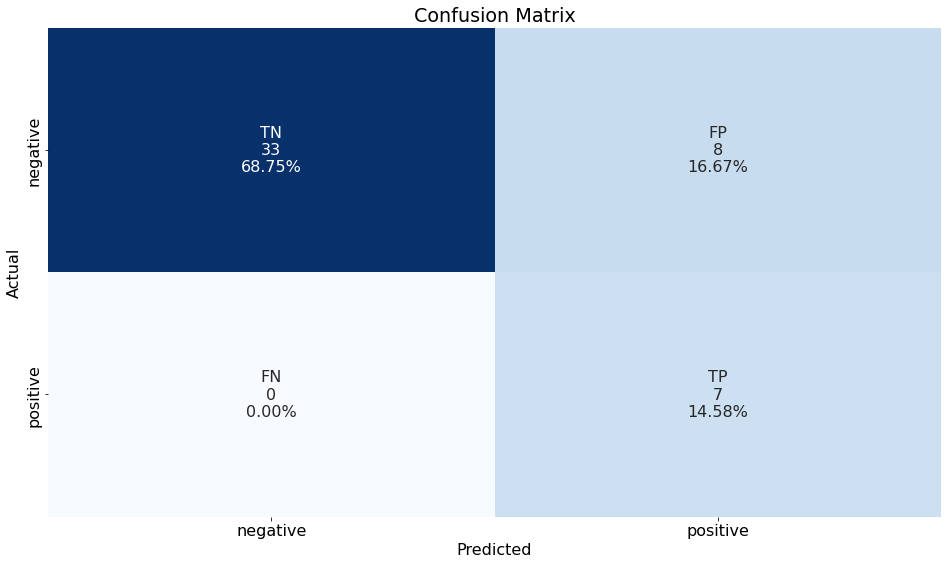

In [19]:
conf_plot(y_true = y_true, y_pred = y_pred)

## 7.3. Checking Overfitting

In [20]:
recall_score(
    average = 'macro',
    y_true = y_true,
    y_pred = y_pred
)

0.9024390243902439

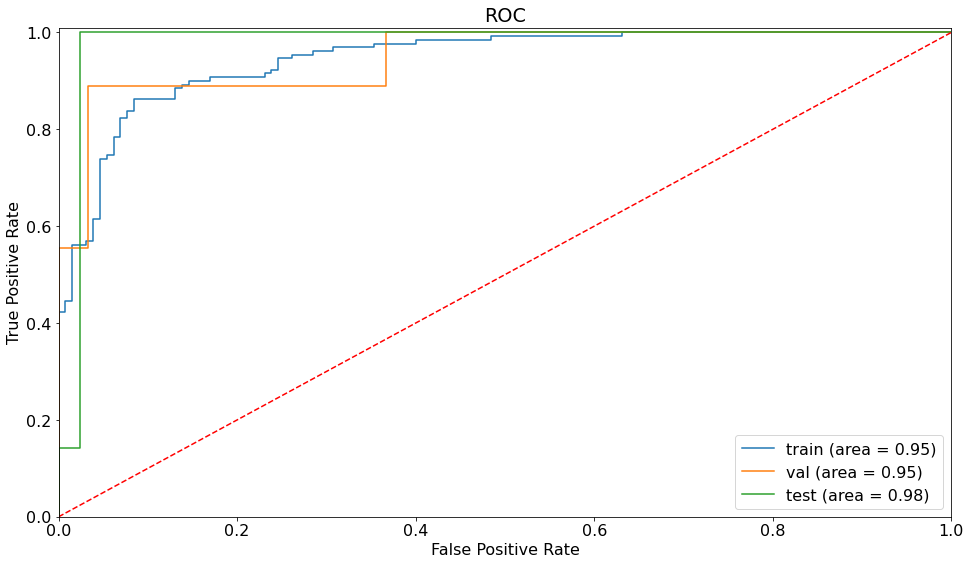

In [21]:
roc_all_split(clf = final_model, sample = chosen_row[ 'sample' ])

## 7.4. Frequency Ranking

[[-0.32340005 -0.43501833 -0.58909672  0.65893363 -0.29704576 -0.44002901
   0.56528821]]


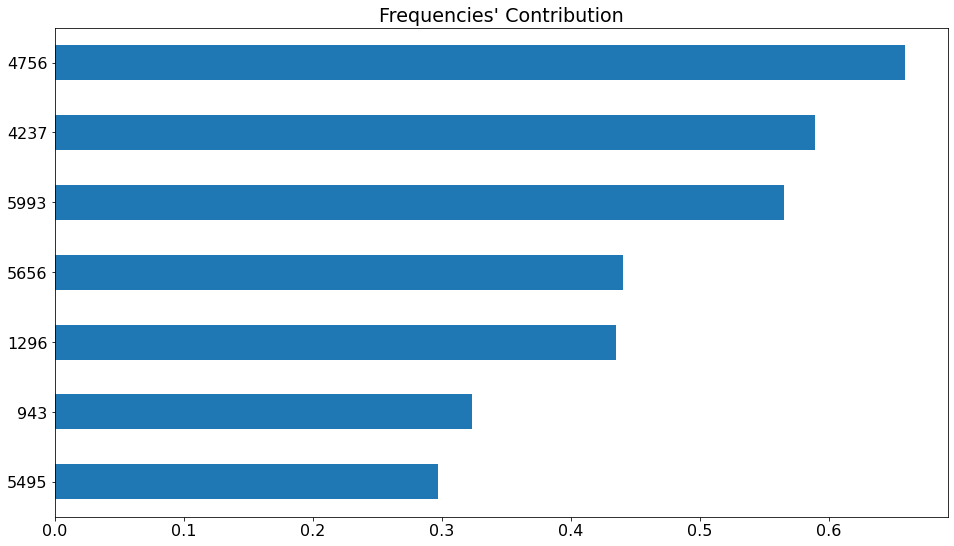

In [22]:
plot_contributions(
    pipe = final_model, 
    frequencies = chosen_row[ 'frequencies' ]
)

## 7.5. Checking Correlation

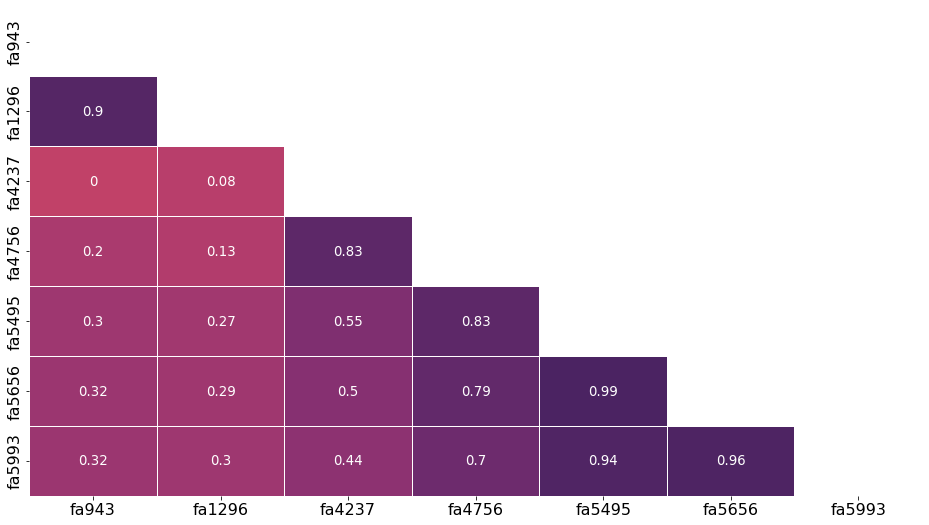

In [23]:
plot_correlation(columns = chosen_row[ 'columns' ])

## 7.6. Plotting Absorbance

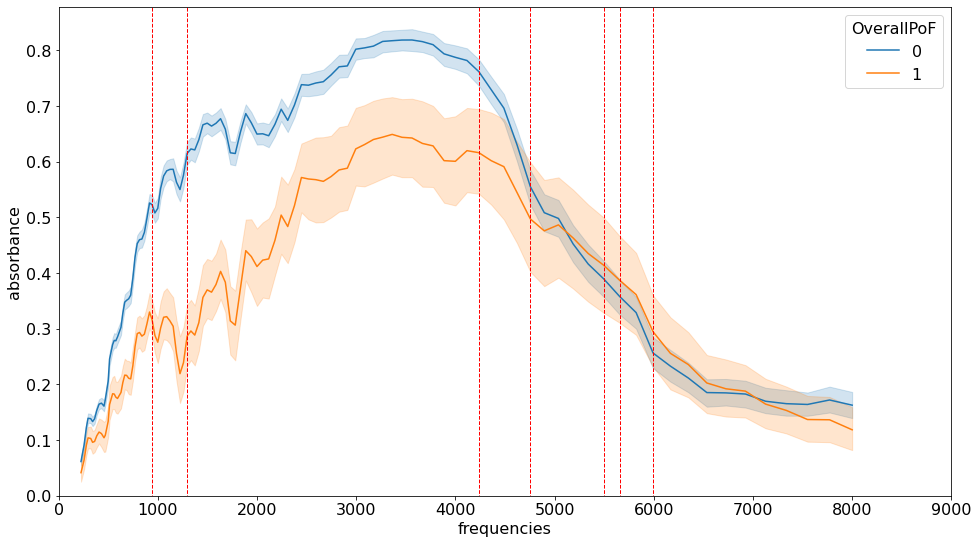

In [24]:
plot_absorbance(
    frequencies = chosen_row[ 'frequencies' ]
)